<a href="https://colab.research.google.com/github/JohnYCLam/MachineLearning/blob/main/Reinforcement_Learning_Multi_armed_Bandit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-armed Bandit and Experiment Classes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from collections import Counter

In [2]:
def random_argmax(value_list):
    list_size = len(value_list)
    permute_seq = np.random.permutation(range(1, list_size +1))
    values = np.asarray(value_list)
    criterion = values.max()
    filter = (values == criterion)
    max_index = np.argmax(permute_seq * filter)
    #print(permute_seq, criterion, filter, permute_seq * filter, max_index)
    return max_index

In [3]:
class Base_MAB:

    def __init__(self, true_mean, *args):
        self.true_mean = true_mean
        if args != ():
            self.arg = args[0]
        self.estimate_mean = 0.0
        self.n_steps = 0

    def reset(self):
        if hasattr(self, 'arg'):
            self.__init__(self.true_mean, self.arg)
        else:
            self.__init__(self.true_mean)

    def return_reward(self):
        reward = max(0.0, self.true_mean + np.random.randn())
        return reward

    def update(self):
        reward = self.return_reward()
        self.n_steps += 1
        self.estimate_mean = (1 - 1/self.n_steps) * self.estimate_mean + 1/self.n_steps * reward

In [4]:
class Base_Experiment:

    def __init__(self, mab, true_means, *args):
        self.mab = mab
        self.true_means = true_means
        if args != ():
            self.arg = args[0]
            self.mabs = [mab(true_mean, self.arg) for true_mean in true_means]
        else:
            self.mabs = [mab(true_mean) for true_mean in true_means]
        self.cumulative_reward = 0.0
        self.n_mabs = len(self.mabs)
        self.mabs_selected = []
        self.mean_rewards = None

    def reset(self):
        if hasattr(self, 'arg'):
            self.__init__(self.mab, self.true_means, self.arg)
        else:
            self.__init__(self.mab, self.true_means)

    def select(self):
        current_means = [mab.estimate_mean for mab in self.mabs]
        #print(current_means)
        max_index = random_argmax(current_means)
        return max_index

    def update(self, max_index):
        mab = self.mabs[max_index]
        reward = mab.return_reward()
        mab.update()
        self.cumulative_reward += reward

    def run(self, n_steps):

        self.mean_rewards = np.zeros((n_steps + 1, self.n_mabs))

        for n in range(1, n_steps + 1):
            max_index = self.select()
            self.update(max_index)
            self.mabs_selected.append(max_index)
            self.mean_rewards[n, :] = [mab.estimate_mean for mab in self.mabs]

In [5]:
def run_epochs(Experiment, MAB, true_means, epoch_length = 30, epochs = 50, **kwargs):
    mean_rewards_per_param = []
    percent_optimal_mab_selected_per_param = []
    optimal_index = true_means.index(max(true_means))

    for param_list in kwargs.values():
        for param in param_list:
            mean_reward = 0.0
            percent_optimal_mab_selected = 0.0
            experiment = Experiment(MAB, true_means, param)

            for epoch in range(1, epochs + 1):
                #print(f'a: {experiment.epsilon}')
                experiment.run(epoch_length)
                #print(f'r: {experiment.epsilon}')
                mean_reward =  (mean_reward * (epoch - 1) + (experiment.cumulative_reward/epoch_length)) / epoch
                percent_optimal_mab_selected =  (percent_optimal_mab_selected * (epoch - 1) + Counter(experiment.mabs_selected)[optimal_index]) / epoch
                experiment.reset()
                #print(f'b: {experiment.epsilon}')
            mean_rewards_per_param.append(mean_reward)
            percent_optimal_mab_selected_per_param.append(percent_optimal_mab_selected/epoch_length)

    return mean_rewards_per_param, percent_optimal_mab_selected_per_param

In [6]:
def percent_mabs_selected_per_timestep(experiment, time_step):
    percent_mabs_selected = np.zeros((time_step + 1, experiment.n_mabs))
    for t in range(1, time_step + 1):
        mab_selected = experiment.mabs_selected[t - 1]
        percent_mabs_selected[t, :] = percent_mabs_selected[t - 1, :]
        percent_mabs_selected[t, mab_selected] += 1

    percent_mabs_selected = percent_mabs_selected[1:, :] / np.array(range(1, 121)).reshape((-1,1))

    return percent_mabs_selected

In [7]:
true_means = [k*2 + 2 for k in range(1, 6)]

#Greedy Algorithm

In [ ]:
#Base case is same as Greedy Approach
experiment = Base_Experiment(Base_MAB, true_means)
experiment.reset()
experiment.run(5)

In [ ]:
experiment.mabs_selected

[2, 2, 2, 2, 2]

In [ ]:
experiment.mean_rewards

array([[0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 8.51738744, 0.        , 0.        ],
       [0.        , 0.        , 7.89122757, 0.        , 0.        ],
       [0.        , 0.        , 7.21617375, 0.        , 0.        ],
       [0.        , 0.        , 7.2143476 , 0.        , 0.        ],
       [0.        , 0.        , 7.65734419, 0.        , 0.        ]])

In [ ]:
experiment.cumulative_reward

40.82986860331201

In [ ]:
experiment = Base_Experiment(Base_MAB, true_means)
mabs_selected = []
for _ in range(100):
    experiment.reset()
    experiment.run(1)
    mabs_selected.append(experiment.mabs_selected[0])

In [ ]:
#roughly 20 for each mab
Counter(mabs_selected)

Counter({3: 25, 1: 21, 0: 17, 2: 16, 4: 21})

# Optimistic Greedy Algorithm

In [ ]:
class Optimistic_MAB(Base_MAB):
    def __init__(self, true_mean, *args):
       super().__init__(true_mean, *args)
       self.estimate_mean = self.arg

    def update(self):
        reward = self.return_reward()
        self.n_steps += 1
        if self.arg == 0.0:
            self.estimate_mean = (1 - 1/self.n_steps) * self.estimate_mean + 1/self.n_steps * reward
        else:
            self.estimate_mean = (1 - 1/(self.n_steps + 1)) * self.estimate_mean + 1/(self.n_steps + 1) * reward

In [ ]:
class Optimistic_Experiment(Base_Experiment):
    def run(self, n_steps):

        self.mean_rewards = np.full((n_steps + 1, self.n_mabs), self.arg)

        for n in range(1, n_steps + 1):
            max_index = self.select()
            self.update(max_index)
            self.mabs_selected.append(max_index)
            self.mean_rewards[n, :] = [mab.estimate_mean for mab in self.mabs]

In [ ]:
# Set initial estimate to a high value for exploration at the early stage
# last param is initial estimate
optim_greedy_exp = Optimistic_Experiment(Optimistic_MAB, true_means, 20.0)
optim_greedy_exp.run(30)

In [ ]:
optim_greedy_exp.mabs_selected

[3,
 1,
 4,
 2,
 0,
 4,
 3,
 4,
 4,
 4,
 2,
 4,
 4,
 3,
 4,
 1,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4]

In [ ]:
optim_greedy_exp.mean_rewards

array([[20.        , 20.        , 20.        , 20.        , 20.        ],
       [20.        , 20.        , 20.        , 15.50598078, 20.        ],
       [20.        , 13.3269741 , 20.        , 15.50598078, 20.        ],
       [20.        , 13.3269741 , 20.        , 15.50598078, 16.45360039],
       [20.        , 13.3269741 , 14.02213644, 15.50598078, 16.45360039],
       [11.74974044, 13.3269741 , 14.02213644, 15.50598078, 16.45360039],
       [11.74974044, 13.3269741 , 14.02213644, 15.50598078, 15.09097837],
       [11.74974044, 13.3269741 , 14.02213644, 13.38516472, 15.09097837],
       [11.74974044, 13.3269741 , 14.02213644, 13.38516472, 14.4809574 ],
       [11.74974044, 13.3269741 , 14.02213644, 13.38516472, 14.07603031],
       [11.74974044, 13.3269741 , 14.02213644, 13.38516472, 13.78471446],
       [11.74974044, 13.3269741 , 11.92514377, 13.38516472, 13.78471446],
       [11.74974044, 13.3269741 , 11.92514377, 13.38516472, 13.70386629],
       [11.74974044, 13.3269741 , 11.9

In [ ]:
optim_greedy_exp.cumulative_reward

321.61651795594395

In [ ]:
mean_rewards_per_param, percent_optimal_mab_selected_per_param = run_epochs(Optimistic_Experiment, Optimistic_MAB, true_means, initial_estimates = range(100))

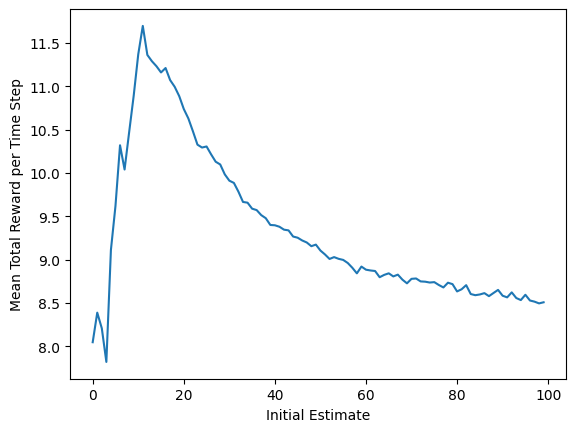

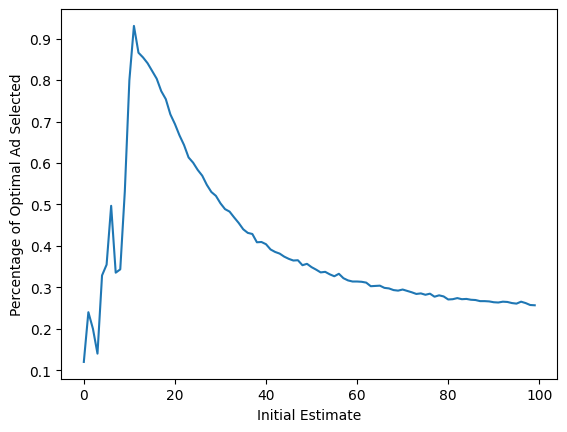

In [ ]:
plt.plot(mean_rewards_per_param)
plt.xlabel('Initial Estimate')
plt.ylabel('Mean Total Reward per Time Step')
plt.show()

plt.plot(percent_optimal_mab_selected_per_param)
plt.xlabel('Initial Estimate')
plt.ylabel('Percentage of Optimal Ad Selected')
plt.show()

# Epsilon-Greedy Algorithm

In [ ]:
class Eps_Greedy_Experiment(Base_Experiment):

    def select(self):
        p = np.random.random()
        if p < self.arg:
            max_index = np.random.choice(self.n_mabs)

        else:
            current_means = [mab.estimate_mean for mab in self.mabs]
            max_index = random_argmax(current_means)

        return max_index

In [ ]:
experiment = Eps_Greedy_Experiment(Base_MAB, true_means, 1.0)

In [ ]:
experiment.run(500)

In [ ]:
#same as uniformly random selection
#roughly 100 counts for each mab
Counter(experiment.mabs_selected)

Counter({1: 110, 3: 97, 0: 89, 4: 94, 2: 110})

In [ ]:
experiment.cumulative_reward

3979.7878878228667

In [ ]:
experiment.mean_rewards

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  5.7698423 ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  5.7698423 ,  0.        ,  8.96669219,  0.        ],
       ...,
       [ 4.20877723,  5.95569277,  8.11460661,  9.98021347, 11.84870122],
       [ 4.20877723,  5.95569277,  8.13031494,  9.98021347, 11.84870122],
       [ 4.20877723,  5.95569277,  8.13567672,  9.98021347, 11.84870122]])

In [ ]:
epsilons = np.array(range(21))/20
mean_rewards_per_param, percent_optimal_mab_selected_per_param = run_epochs(Eps_Greedy_Experiment, Base_MAB, true_means, epoch_length = 50, epochs = 100, epsilons = epsilons)

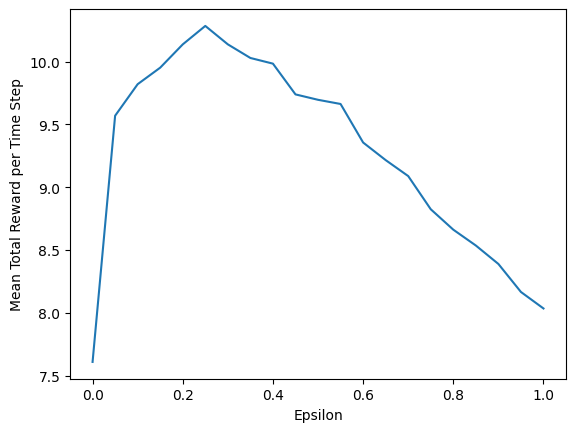

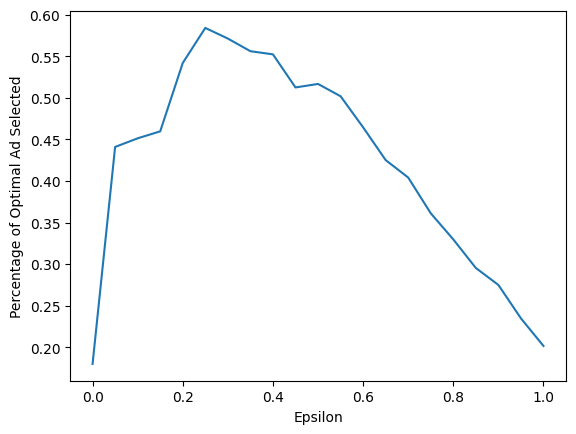

In [ ]:
plt.plot(epsilons, mean_rewards_per_param)
plt.xlabel('Epsilon')
plt.ylabel('Mean Total Reward per Time Step')
plt.show()

plt.plot(epsilons, percent_optimal_mab_selected_per_param)
plt.xlabel('Epsilon')
plt.ylabel('Percentage of Optimal Ad Selected')
plt.show()

#Exponential Weight Algorithm (EXP3)

#Upper Confidence Bound (UCB) Algorithm

In [ ]:
# General UCB formula for Action A_t chosen at time step t:
# A_t = argmax_{a} [Q_t(a) + c*sqrt(log(t)/N_t(a)], for all actions a
# where Q_t (a) is the estimated value of mean rewward Q(a) at time t
# N_t (a) is the number of times that action a has been selected prior to time t
# c is the hyperparameter which controls the 'height' of upper confidence bound,
# or in another view, the strength of exploration

class UCB_MAB(Base_MAB):
    def __init__(self, true_mean, *args):
       super().__init__(true_mean, *args)
       self.estimate_mean = float('inf')

    def confidence_bound(self, time_step):
        if self.n_steps == 0:
            return float('inf')
        else:
            return self.arg * np.sqrt(np.log(time_step) / self.n_steps)

    def update(self):
        if self.estimate_mean == float('inf'):
            self.estimate_mean = 0.0

        reward = self.return_reward()
        self.n_steps += 1
        self.estimate_mean = (1 - 1/self.n_steps) * self.estimate_mean + 1/self.n_steps * reward

In [ ]:
class UCB_Experiment(Base_Experiment):
    def select(self, time_step):
        current_means = [mab.estimate_mean + mab.confidence_bound(time_step) for mab in self.mabs]
        max_index = random_argmax(current_means)
        return max_index

    def run(self, n_steps):

        self.mean_rewards = np.full((n_steps + 1, self.n_mabs), float('inf'))

        for t in range(1, n_steps + 1):
            max_index = self.select(t)
            self.update(max_index)
            self.mabs_selected.append(max_index)
            self.mean_rewards[t, :] = [mab.estimate_mean for mab in self.mabs]


In [ ]:
confidence_levels = np.array(range(21))/10

mean_rewards_per_param, percent_optimal_mab_selected_per_param = run_epochs(UCB_Experiment, UCB_MAB, true_means, epoch_length = 120, epochs = 80, confidence_levels = confidence_levels)

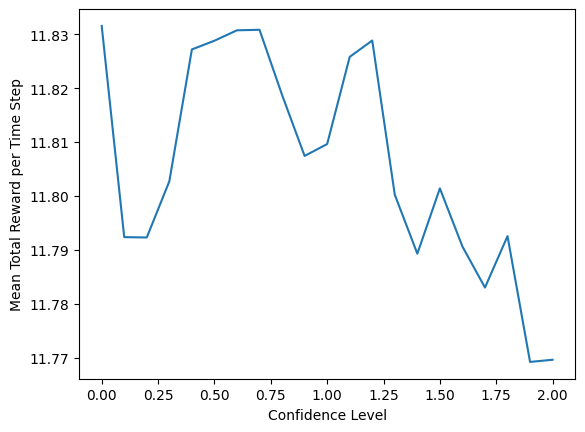

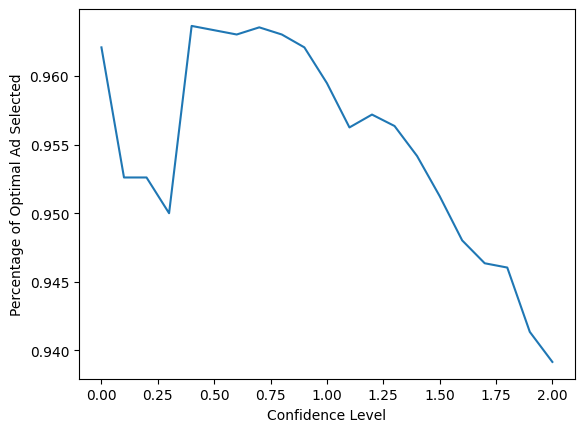

In [ ]:
plt.plot(confidence_levels, mean_rewards_per_param)
plt.xlabel('Confidence Level')
plt.ylabel('Mean Total Reward per Time Step')
plt.show()

plt.plot(confidence_levels, percent_optimal_mab_selected_per_param)
plt.xlabel('Confidence Level')
plt.ylabel('Percentage of Optimal Ad Selected')
plt.show()

In [ ]:
time_step = 120
experiment = UCB_Experiment(UCB_MAB, true_means, 0.6)
experiment.run(time_step)

In [ ]:
Counter(experiment.mabs_selected)

Counter({2: 1, 1: 1, 0: 1, 3: 2, 4: 115})

In [ ]:
percent_mabs_selected = percent_mabs_selected_per_timestep(experiment, time_step)

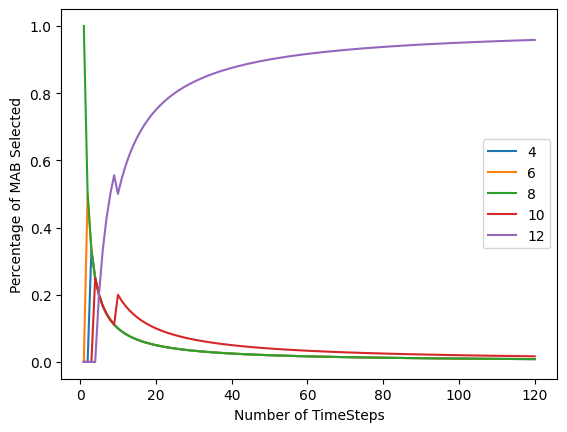

In [ ]:
plt.plot(range(1, time_step + 1), percent_mabs_selected)
plt.xlabel('Number of TimeSteps')
plt.ylabel('Percentage of MAB Selected')
plt.legend(true_means)
plt.show()

## UCB1 Algorithm
Dervied from Hoeffding's inequality,
$P(Q(a) > Q_{t}(a) + u_{t}(a)) \leq e^{-2tu_{t}^2(a)}$

where $u_{t}(a)$ is an upper confidence bound depending on timestep t and action a

Set $p = e^{-2tu_{t}^2(a)}$ for small p,

we get $ u_{t}(a) = \sqrt\frac{-\log p}{2N_{t}(a)}$

For UCB1, further substitute $p = t^{-4}$ in the hope to reduce p a lot in time t

In [ ]:
# Substitute c = sqrt(2)
time_step = 120
experiment = UCB_Experiment(UCB_MAB, true_means, np.sqrt(2))
experiment.run(time_step)

In [ ]:
percent_mabs_selected = percent_mabs_selected_per_timestep(experiment, time_step)

In [ ]:
Counter(experiment.mabs_selected)

Counter({2: 1, 1: 1, 3: 4, 0: 1, 4: 113})

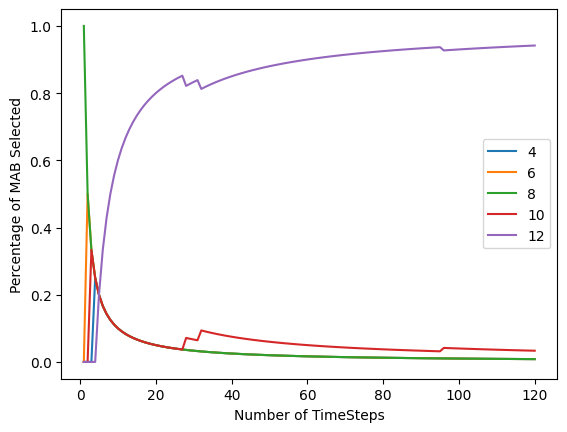

In [ ]:
plt.plot(range(1, time_step + 1), percent_mabs_selected)
plt.xlabel('Number of TimeSteps')
plt.ylabel('Percentage of MAB Selected')
plt.legend(true_means)
plt.show()

## Bayesian UCB Algorithm
Assume prior knowledge on sample distribution - normal distribution
Then can further simplify upper confidence bound $u_{t}(a)$ to $c \frac{\sigma}{\sqrt{N_{t}(a)}}$, where $\sigma$ is the sample standard deviation.
Setting $c = 1.96$, it gives us the upper 95% confidence interval.

In [ ]:
# Assuming the MAB rewards are normally distributed, we can set c = 1.96 to get the 95% confidence upper bound
time_step = 120
experiment = UCB_Experiment(UCB_MAB, true_means, 1.96)
experiment.run(time_step)

In [ ]:
percent_mabs_selected = percent_mabs_selected_per_timestep(experiment, time_step)

In [ ]:
Counter(experiment.mabs_selected)

Counter({3: 3, 4: 114, 2: 1, 1: 1, 0: 1})

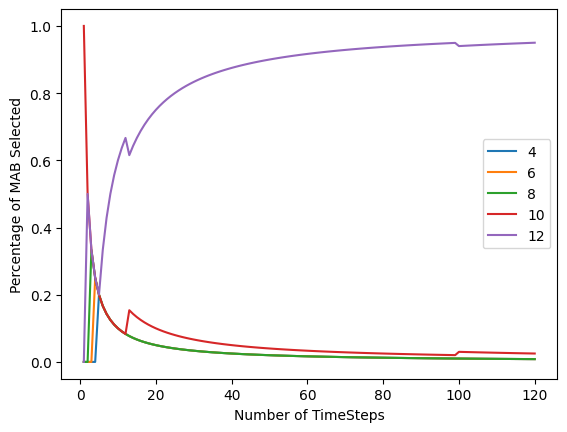

In [ ]:
plt.plot(range(1, time_step + 1), percent_mabs_selected)
plt.xlabel('Number of TimeSteps')
plt.ylabel('Percentage of MAB Selected')
plt.legend(true_means)
plt.show()

# Thompson Sampling Algorithm

## Bernoulli Thompson Sampling Algorithm
Prior Belief is Beta Distribution: $Β(1, 1)$

Likelihood is Bernoulli Distribution: $\text{Bernoulli}(p)$

After $k$ successes and $n - k$ failures

Posterior Distribution is Beta Distribution: $Β(1 + k, 1 + n - k)$

Posterior Predictive is Bernoulli Distribution: $\text{Bernoulli}\big(\frac{1 + k}{2 + n}\big)$

In [8]:
class Bernoulli_Thompson_MAB(Base_MAB):
    def __init__(self, true_mean, *args):
       super().__init__(true_mean, *args)
       self.alpha = 1
       self.beta = 1

    def return_reward(self):

        return np.random.random() < self.true_mean

    def update(self):
        #there is no estimated mean. Instead of estimated mean, we update alpha and beta
        #which models the posterior distribution of the parameter p given observed samples
        reward = self.return_reward()
        self.n_steps += 1
        self.alpha += reward
        self.beta += (1 - reward)


In [9]:
class Bernoulli_Thompson_Experiment(Base_Experiment):
    def select(self):
        current_means = [np.random.beta(mab.alpha, mab.beta) for mab in self.mabs]
        max_index = random_argmax(current_means)
        return max_index

In [10]:
true_means = [0.1, 0.3, 0.5, 0.7, 0.9]
time_step = 120
experiment = Bernoulli_Thompson_Experiment(Bernoulli_Thompson_MAB, true_means)
experiment.run(time_step)

In [12]:
Counter(experiment.mabs_selected)

Counter({0: 3, 3: 24, 1: 2, 2: 15, 4: 76})

In [11]:
percent_mabs_selected = percent_mabs_selected_per_timestep(experiment, time_step)

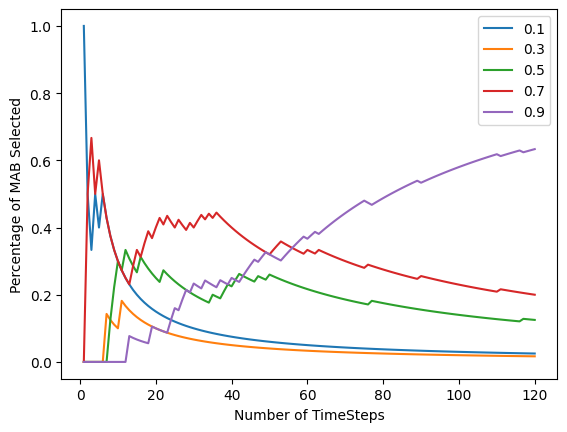

In [13]:
plt.plot(range(1, time_step + 1), percent_mabs_selected)
plt.xlabel('Number of TimeSteps')
plt.ylabel('Percentage of MAB Selected')
plt.legend(true_means)
plt.show()

##Gaussian Thompson Sampling Algorithm

# Legacy

In [ ]:
class BaseAds:

  # Create basic Ads class

  def __init__(self,q):
    self.q = q    #true reward value
    self.initialize() #reset Ads

  def initialize(self):
    self.Q = 0 #estimate of the Ads reward value
    self.n = 0 #number of times this Ads has been tried
    self.reward = [] #for BayesianUCBAds

  def charge(self):

    # Return a random reward
    # Reward is a Bernoulli Distribution with success probability q
    #value = np.random.binomial(1,self.q)
    #return value
     value = np.random.randn() + self.q
     return 0 if value < 0 else value

  def update(self, R):

    # Update this ads after it has returned reward value R

    # update no. of times this ads has been tried
    self.n += 1

    # Update new estimate of mean Q from previous estimate
    self.Q = (1- 1.0/self.n)*self.Q + (1.0/self.n)*R

  def sample(self,t):
     return self.Q

## **Create Ads Tester Class**

In [ ]:
Ads_order = [2, 1, 3, 5, 4]

In [ ]:
Ads_order = [9.95, 10.0, 9.98, 9, 9.99]

In [ ]:
def random_argmax(value_list):
  # a random tie-breaking argmax
  values = np.asarray(value_list)
  return np.argmax(np.random.random(values.shape) * (values==values.max()))

class AdsTester():

  # Create and test a set of ads over a single test run

  def __init__(self, ad = BaseAds, Ads_order = Ads_order, **kwargs):
    # Create supplied ads type with mean/success value defined by ads order


    self.ads = [ad( q*2+2, **kwargs) for q in Ads_order]
    # self.ads = [ad( 1/q, **kwargs) for q in Ads_order]
    self.InitialReward = self.ads[0].Q
    self.number_of_ads = len(Ads_order)
    self.Cumulative_Reward = 0
    self.UCB = 0

  def initialize_run(self):
    self.Cumulative_Reward = 0
    self.UCB = 0
    for ad in self.ads: ad.initialize()

  def charge_and_update(self, ads_index):
    # Return from selected ads and update its mean reward
    reward = self.ads[ads_index].charge()
    self.ads[ads_index].update(reward)
    self.Cumulative_Reward += reward

  def select_ads(self, t):
    # Select the ads with current highest mean reward Q
    # In case multiple ads with same highest Q, select at random among them
    ads_index = random_argmax([ad.sample(t+1) for ad in self.ads])
    optimal_index = np.argmax([ad.q for ad in self.ads])
    return ads_index, optimal_index

  def run(self, number_of_steps):
    #Run trial for pre-defined no. of steps
    self.initialize_run()
    Ads_Selected = []
    Mean_Reward_each_Ad = np.full((1,len(Ads_order)), self.InitialReward)

    for t in range(number_of_steps):
      ads_index = self.select_ads(t)[0]
      self.charge_and_update(ads_index)

      Ads_Selected.append(ads_index)
      Mean_Reward_each_Ad = np.r_[Mean_Reward_each_Ad,[[ad.sample(t+1) for ad in self.ads]]]

    return Ads_Selected, Mean_Reward_each_Ad, self.Cumulative_Reward


In [ ]:
TestRun = AdsTester()
TestRun.run(10)

([2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
 array([[0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 8.15650291, 0.        , 0.        ],
        [0.        , 0.        , 8.3576999 , 0.        , 0.        ],
        [0.        , 0.        , 8.47962084, 0.        , 0.        ],
        [0.        , 0.        , 8.10571324, 0.        , 0.        ],
        [0.        , 0.        , 8.16884732, 0.        , 0.        ],
        [0.        , 0.        , 7.83672155, 0.        , 0.        ],
        [0.        , 0.        , 7.95230118, 0.        , 0.        ],
        [0.        , 0.        , 8.09396841, 0.        , 0.        ],
        [0.        , 0.        , 8.01060506, 0.        , 0.        ],
        [0.        , 0.        , 7.94424559, 0.        , 0.        ]]),
 79.44245589968773)

## **Optimistic Greedy Algorithm**

In [ ]:
class OptimisticAds(BaseAds):
  def __init__(self, q, initial_estimate):

    self.W = initial_estimate

    #pass true reward value to base ads
    super().__init__(q)

    self.Q = initial_estimate
    self.n = 1

  def initialize(self):

    self.Q = self.W
    self.n = 1

In [ ]:
TestRun = AdsTester(ad = OptimisticAds, initial_estimate=20)

from collections import Counter

Experiment = TestRun.run(30)
print(Experiment)
#Dict = Counter(Experiment[0])
#print(Dict)
#print(Experiment[1])

([2, 0, 4, 3, 1, 3, 3, 4, 2, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], array([[20.        , 20.        , 20.        , 20.        , 20.        ],
       [20.        , 20.        , 14.23321331, 20.        , 20.        ],
       [12.77178968, 20.        , 14.23321331, 20.        , 20.        ],
       [12.77178968, 20.        , 14.23321331, 20.        , 14.42902154],
       [12.77178968, 20.        , 14.23321331, 16.46228813, 14.42902154],
       [12.77178968, 11.8464862 , 14.23321331, 16.46228813, 14.42902154],
       [12.77178968, 11.8464862 , 14.23321331, 15.03785575, 14.42902154],
       [12.77178968, 11.8464862 , 14.23321331, 14.16182584, 14.42902154],
       [12.77178968, 11.8464862 , 14.23321331, 14.16182584, 12.98796134],
       [12.77178968, 11.8464862 , 12.20685804, 14.16182584, 12.98796134],
       [12.77178968, 11.8464862 , 12.20685804, 13.49579397, 12.98796134],
       [12.77178968, 11.8464862 , 12.20685804, 13.33065578, 12.98796134],
       [12.77178968

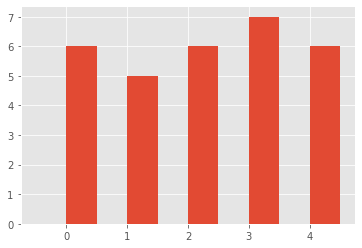

In [ ]:
plt.style.use('ggplot')
plt.hist(Experiment[0], range=[-0.5,4.5])
plt.show()

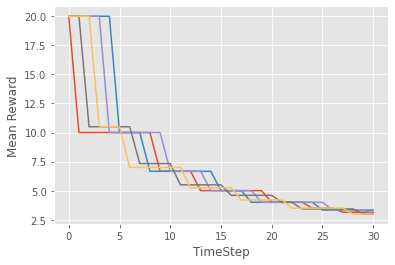

In [ ]:
plt.plot(Experiment[1][:,0])
plt.plot(Experiment[1][:,1])
plt.plot(Experiment[1][:,2])
plt.plot(Experiment[1][:,3])
plt.plot(Experiment[1][:,4])
plt.xlabel('TimeStep')
plt.ylabel('Mean Reward')
plt.show()

In [ ]:
from collections import Counter
Mean_Total_Reward_Diff_Initial = []
Percentage_Selected_Optimal_Ad = []
timestep = 40
repeation = 300
Initial_Max = 100
for i in range(0,Initial_Max + 1,1):
  TestRun = AdsTester(ad = OptimisticAds, initial_estimate=i)
  Experiment_Mean_Reward = 0
  Experiment_Selected_Optimal_Ad = 0

  for j in range(1, repeation + 1):
    #need initialize ads & tester
    Experiment = TestRun.run(timestep)
    #print(Experiment[3])
    Experiment_Mean_Reward =  (Experiment_Mean_Reward * (j-1) + (Experiment[2]/timestep)) / j
    Experiment_Selected_Optimal_Ad =  (Experiment_Selected_Optimal_Ad * (j-1) + Counter(Experiment[0])[3]) / j
  Mean_Total_Reward_Diff_Initial.append(Experiment_Mean_Reward)
  Percentage_Selected_Optimal_Ad.append(Experiment_Selected_Optimal_Ad/timestep)

#print(Mean_Total_Reward_Diff_Initial)
#print(Percentage_Selected_Optimal_Ad)

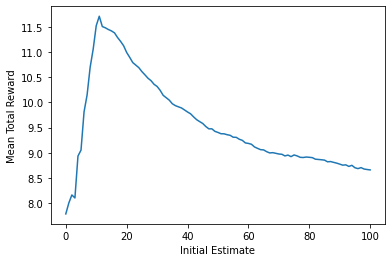

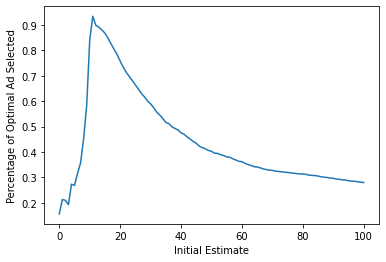

In [ ]:
plt.plot(Mean_Total_Reward_Diff_Initial)
plt.xlabel('Initial Estimate')
plt.ylabel('Mean Total Reward')
plt.show()

plt.plot(Percentage_Selected_Optimal_Ad)
plt.xlabel('Initial Estimate')
plt.ylabel('Percentage of Optimal Ad Selected')
plt.show()

## **Epsilon Greedy Algorithm**

In [ ]:
class EpsilonGreedyAds(AdsTester):

  def __init__(self, epsilon = 0):

    #create a standard ads tester
    super().__init__()

    #save the hyperparameter value
    self.epsilon = epsilon

   # Change the definition of select_ads in original adstester
  def select_ads(self, t):
    #Draw a random number
    p = np.random.random()
    #If p < epsilon, then random select an ad:
    if p < self.epsilon:
      ads_index = np.random.choice(self.number_of_ads)
    else:
      # select ads with highest current mean reward
      ads_index = random_argmax([ad.sample(t+1) for ad in self.ads])
    return ads_index, ads_index

In [ ]:
from collections import Counter
Mean_Total_Reward_Diff_Initial = []
Percentage_Selected_Optimal_Ad = []
timestep = 100
repeation = 100
epsilon_max = 1
i = 0.0
while i <= 1:
  TestRun = EpsilonGreedyAds(epsilon=i)
  Experiment_Mean_Reward = 0
  Experiment_Selected_Optimal_Ad = 0

  for j in range(1, repeation + 1):
    Experiment = TestRun.run(timestep)
    #print(Experiment[3])
    Experiment_Mean_Reward =  (Experiment_Mean_Reward * (j-1) + (Experiment[2]/timestep)) / j
    Experiment_Selected_Optimal_Ad =  (Experiment_Selected_Optimal_Ad * (j-1) + Counter(Experiment[0])[3]) / j
  Mean_Total_Reward_Diff_Initial.append(Experiment_Mean_Reward)
  Percentage_Selected_Optimal_Ad.append(Experiment_Selected_Optimal_Ad/timestep)
  i += 0.05
#print(Mean_Total_Reward_Diff_Initial)
#print(Percentage_Selected_Optimal_Ad)

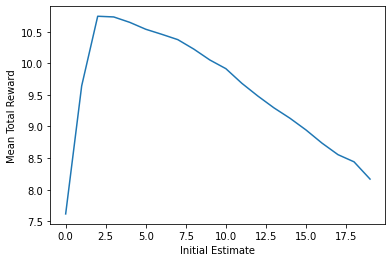

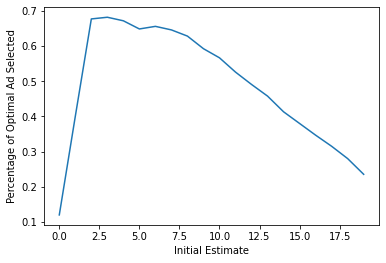

In [ ]:
plt.plot(Mean_Total_Reward_Diff_Initial)
plt.xlabel('Initial Estimate')
plt.ylabel('Mean Total Reward')
plt.show()

plt.plot(Percentage_Selected_Optimal_Ad)
plt.xlabel('Initial Estimate')
plt.ylabel('Percentage of Optimal Ad Selected')
plt.show()

## **Upper Condifence Bound Algorithm**

### Generic UCB with Confidence Hyperparameter c

In [ ]:
# General UCB formula for Action A_t chosen at time step t:
# A_t = argmax_{a} [Q_t(a) + c*sqrt(log(t)/N_t(a)], for all actions a
# where Q_t (a) is the estimated value of mean rewward Q(a) at time t
# N_t (a) is the number of times that action a has been selected prior to time t
# c is the hyperparameter which controls the 'height' of upper confidence bound,
# or in another view, the strength of exploration

class UCBAds(BaseAds):

  def __init__(self, q, confidence_level):

    # initialize UCB Ads
    #store confidence level
    self.confidence_level = confidence_level

    #pass true reward value to base Ads
    super().__init__(q)

  def uncertainity(self, t):
    if self.n == 0: return float('inf')
    else: return self.confidence_level * np.sqrt(np.log(t)/self.n)

  def sample(self,t):
    return self.Q + self.uncertainity(t)

  def true_sample(self, t):
    return self.Q

In [ ]:
class UCBTester(AdsTester):

  def charge_and_update(self, ads_index):
    # Return from selected ads and update its mean reward
    reward = self.ads[ads_index].charge()
    self.ads[ads_index].update(reward)
    self.Cumulative_Reward += reward

  def run(self, number_of_steps):
    #Run trial for pre-defined no. of steps
    self.initialize_run()
    Ads_Selected = []
    Mean_Reward_each_Ad = np.full((1,len(Ads_order)), self.InitialReward)
    UCB_each_Ad = np.full((1,len(Ads_order)), self.InitialReward)

    for t in range(number_of_steps):
      ads_index = self.select_ads(t)[0]
      self.charge_and_update(ads_index)
      Ads_Selected.append(ads_index)
      Mean_Reward_each_Ad = np.r_[Mean_Reward_each_Ad,[[ad.true_sample(t+1) for ad in self.ads]]]
      UCB_each_Ad = np.r_[UCB_each_Ad,[[ad.sample(t+1) for ad in self.ads]]]
      UCB = self.ads[ads_index].sample(t+1)
      self.UCB += UCB

    return Ads_Selected, Mean_Reward_each_Ad, self.Cumulative_Reward, UCB_each_Ad, self.UCB

### UCB1 (Traditional UCB Algorithm)

Dervied from Hoeffding's inequality,
$P(Q(a) > Q_{t}(a) + u_{t}(a)) \leq e^{-2tu_{t}^2(a)}$

where $u_{t}(a)$ is an upper confidence bound depending on timestep t and action a

Set $p = e^{-2tu_{t}^2(a)}$ for small p,

we get $ u_{t}(a) = \sqrt\frac{-\log p}{2N_{t}(a)}$

For UCB1, further substitute $p = t^{-4}$ in the hope to reduce p a lot in time t

In [ ]:
# Traditional UCB1 algorithm
TestRun = AdsTester(ad = UCBAds, confidence_level = np.sqrt(2))

from collections import Counter

Experiment = TestRun.run(25)
print(Experiment)

([1, 0, 2, 4, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [        inf,  3.83937916,         inf,         inf,         inf],
       [ 8.48115883,  5.01678918,         inf,         inf,         inf],
       [ 8.78605262,  5.32168296,  9.89862595,         inf,         inf],
       [ 8.96885803,  5.50448838, 10.08143136,         inf, 12.98917695],
       [ 9.09787139,  5.63350173, 10.21044472, 13.29040053, 13.11819031],
       [ 9.19676728,  5.73239763, 10.30934061, 12.7566813 , 13.2170862 ],
       [ 9.27651851,  5.81214886, 10.38909184, 12.81307393, 11.83777152],
       [ 9.34308279,  5.87871314, 10.45565612, 12.63666789, 11.88483957],
       [ 9.40004296,  5.9356733 , 10.51261629, 12.66228183, 11.92511649],
       [ 9.44971484,  5.98534518, 10.56228817, 12.97206297, 11.96023981],
       [ 9.49367816,  6.0293085 , 10.60625149, 12.71322529, 11.99132658],
       [ 9.53305662,  6.06868696, 

[0.308, 0.42800000000000005, 0.436, 0.545, 0.57, 0.5619999999999999, 0.6002857142857143, 0.61775, 0.658, 0.6638000000000003, 0.6420000000000006, 0.7088333333333334, 0.7141538461538461, 0.7141428571428572, 0.756, 0.743625, 0.7605882352941173, 0.758777777777778, 0.6986315789473686, 0.7887000000000003]


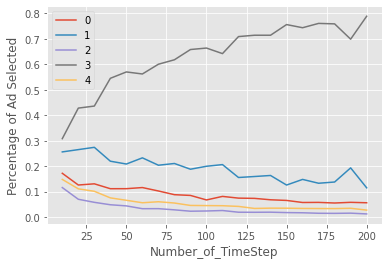

In [ ]:
number_of_time_step = 200
number_of_run = 50
Percentage_Selected_Ad_0 = []
Experiment_Selected_Ad_0 = 0
Percentage_Selected_Ad_1 = []
Experiment_Selected_Ad_1 = 0
Percentage_Selected_Ad_2 = []
Experiment_Selected_Ad_2 = 0
Percentage_Selected_Ad_3 = []
Experiment_Selected_Ad_3 = 0
Percentage_Selected_Ad_4 = []
Experiment_Selected_Ad_4 = 0

for i in range(10,number_of_time_step+1,10):

  TestRun = UCBTester(ad = UCBAds, confidence_level = np.sqrt(2))

  for j in range(1, number_of_run + 1):

    Experiment = TestRun.run(i)
    Experiment_Selected_Ad_0 =  (Experiment_Selected_Ad_0 * (j-1) + Counter(Experiment[0])[0]) / j
    Experiment_Selected_Ad_1 =  (Experiment_Selected_Ad_1 * (j-1) + Counter(Experiment[0])[1]) / j
    Experiment_Selected_Ad_2 =  (Experiment_Selected_Ad_2 * (j-1) + Counter(Experiment[0])[2]) / j
    Experiment_Selected_Ad_3 =  (Experiment_Selected_Ad_3 * (j-1) + Counter(Experiment[0])[3]) / j
    Experiment_Selected_Ad_4 =  (Experiment_Selected_Ad_4 * (j-1) + Counter(Experiment[0])[4]) / j

  Percentage_Selected_Ad_0.append(Experiment_Selected_Ad_0/i)
  Percentage_Selected_Ad_1.append(Experiment_Selected_Ad_1/i)
  Percentage_Selected_Ad_2.append(Experiment_Selected_Ad_2/i)
  Percentage_Selected_Ad_3.append(Experiment_Selected_Ad_3/i)
  Percentage_Selected_Ad_4.append(Experiment_Selected_Ad_4/i)

print(Percentage_Selected_Ad_3)
plt.plot(range(10,number_of_time_step+1,10),Percentage_Selected_Ad_0)
plt.plot(range(10,number_of_time_step+1,10),Percentage_Selected_Ad_1)
plt.plot(range(10,number_of_time_step+1,10),Percentage_Selected_Ad_2)
plt.plot(range(10,number_of_time_step+1,10),Percentage_Selected_Ad_3)
plt.plot(range(10,number_of_time_step+1,10),Percentage_Selected_Ad_4)
plt.xlabel('Number_of_TimeStep')
plt.ylabel('Percentage of Ad Selected')
plt.legend([0,1,2,3,4])
plt.show()

[0.39, 0.517, 0.5986666666666667, 0.5599999999999999, 0.6224000000000001, 0.6783333333333336, 0.7514285714285714, 0.72875, 0.7335555555555555, 0.6330000000000002, 0.7327272727272728, 0.7553333333333333, 0.817076923076923, 0.7772857142857142, 0.7645333333333334, 0.7898750000000001, 0.7104705882352941, 0.7421111111111112, 0.811473684210526, 0.7965000000000002]


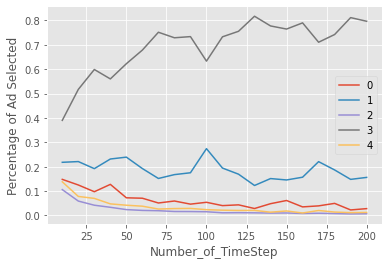

In [ ]:
number_of_time_step = 200
number_of_run = 50
Percentage_Selected_Ad_0 = []
Experiment_Selected_Ad_0 = 0
Percentage_Selected_Ad_1 = []
Experiment_Selected_Ad_1 = 0
Percentage_Selected_Ad_2 = []
Experiment_Selected_Ad_2 = 0
Percentage_Selected_Ad_3 = []
Experiment_Selected_Ad_3 = 0
Percentage_Selected_Ad_4 = []
Experiment_Selected_Ad_4 = 0

for i in range(10,number_of_time_step+1,10):

  TestRun = UCBTester(ad = UCBAds, confidence_level = 0.6)

  for j in range(1, number_of_run + 1):

    Experiment = TestRun.run(i)
    Experiment_Selected_Ad_0 =  (Experiment_Selected_Ad_0 * (j-1) + Counter(Experiment[0])[0]) / j
    Experiment_Selected_Ad_1 =  (Experiment_Selected_Ad_1 * (j-1) + Counter(Experiment[0])[1]) / j
    Experiment_Selected_Ad_2 =  (Experiment_Selected_Ad_2 * (j-1) + Counter(Experiment[0])[2]) / j
    Experiment_Selected_Ad_3 =  (Experiment_Selected_Ad_3 * (j-1) + Counter(Experiment[0])[3]) / j
    Experiment_Selected_Ad_4 =  (Experiment_Selected_Ad_4 * (j-1) + Counter(Experiment[0])[4]) / j

  Percentage_Selected_Ad_0.append(Experiment_Selected_Ad_0/i)
  Percentage_Selected_Ad_1.append(Experiment_Selected_Ad_1/i)
  Percentage_Selected_Ad_2.append(Experiment_Selected_Ad_2/i)
  Percentage_Selected_Ad_3.append(Experiment_Selected_Ad_3/i)
  Percentage_Selected_Ad_4.append(Experiment_Selected_Ad_4/i)

print(Percentage_Selected_Ad_3)
plt.plot(range(10,number_of_time_step+1,10),Percentage_Selected_Ad_0)
plt.plot(range(10,number_of_time_step+1,10),Percentage_Selected_Ad_1)
plt.plot(range(10,number_of_time_step+1,10),Percentage_Selected_Ad_2)
plt.plot(range(10,number_of_time_step+1,10),Percentage_Selected_Ad_3)
plt.plot(range(10,number_of_time_step+1,10),Percentage_Selected_Ad_4)
plt.xlabel('Number_of_TimeStep')
plt.ylabel('Percentage of Ad Selected')
plt.legend([0,1,2,3,4])
plt.show()

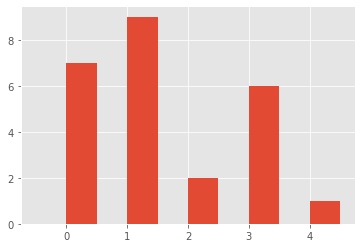

In [ ]:
plt.style.use('ggplot')
plt.hist(Experiment[0], range=[-0.5,4.5])
plt.show()

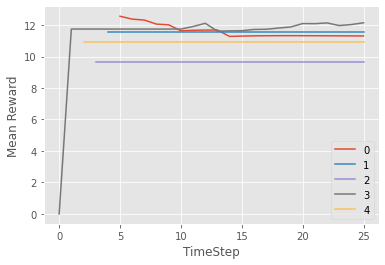

In [ ]:
plt.plot(Experiment[1][:,0])
plt.plot(Experiment[1][:,1])
plt.plot(Experiment[1][:,2])
plt.plot(Experiment[1][:,3])
plt.plot(Experiment[1][:,4])
plt.xlabel('TimeStep')
plt.ylabel('Mean Reward')
plt.legend([0,1,2,3,4])
plt.show()

### Bayesian UCB

Assume prior knowledge on sample distribution - normal distribution
Then can further simplify upper confidence bound $u_{t}(a)$ to $c \frac{\sigma}{\sqrt{N_{t}(a)}}$, where $\sigma$ is the sample standard deviation.
Setting $c = 1.96$, it gives us the upper 95% confidence interval.

In [ ]:
import statistics as stat

class BayesianUCBAds(BaseAds):

  def __init__(self, q, confidence_level):

    # initialize UCB Ads
    #store confidence level
    self.confidence_level = confidence_level
    self.reward = []
    #pass true reward value to base Ads
    super().__init__(q)

  def uncertainity(self, t):
    if self.n == 0: return float('inf')
    else:
      self.reward.append(self.Q)
      return self.confidence_level * stat.pstdev(self.reward)/np.sqrt(self.n)

  def sample(self,t):
    return self.Q + self.uncertainity(t)

  def true_sample(self, t):
    return self.Q


In [ ]:
TestRun = UCBTester(ad = BayesianUCBAds, confidence_level =1.96)

from collections import Counter

Experiment = TestRun.run(25)
print(Experiment[4])

IndexError: ignored

In [ ]:
number_of_time_step = 200
number_of_run = 50
Percentage_Selected_Ad_0 = []
Experiment_Selected_Ad_0 = 0
Percentage_Selected_Ad_1 = []
Experiment_Selected_Ad_1 = 0
Percentage_Selected_Ad_2 = []
Experiment_Selected_Ad_2 = 0
Percentage_Selected_Ad_3 = []
Experiment_Selected_Ad_3 = 0
Percentage_Selected_Ad_4 = []
Experiment_Selected_Ad_4 = 0

for i in range(10,number_of_time_step+1,10):

  TestRun = UCBTester(ad = BayesianUCBAds, confidence_level =1.96)

  for j in range(1, number_of_run + 1):

    Experiment = TestRun.run(i)
    Experiment_Selected_Ad_0 =  (Experiment_Selected_Ad_0 * (j-1) + Counter(Experiment[0])[0]) / j
    Experiment_Selected_Ad_1 =  (Experiment_Selected_Ad_1 * (j-1) + Counter(Experiment[0])[1]) / j
    Experiment_Selected_Ad_2 =  (Experiment_Selected_Ad_2 * (j-1) + Counter(Experiment[0])[2]) / j
    Experiment_Selected_Ad_3 =  (Experiment_Selected_Ad_3 * (j-1) + Counter(Experiment[0])[3]) / j
    Experiment_Selected_Ad_4 =  (Experiment_Selected_Ad_4 * (j-1) + Counter(Experiment[0])[4]) / j

  Percentage_Selected_Ad_0.append(Experiment_Selected_Ad_0/i)
  Percentage_Selected_Ad_1.append(Experiment_Selected_Ad_1/i)
  Percentage_Selected_Ad_2.append(Experiment_Selected_Ad_2/i)
  Percentage_Selected_Ad_3.append(Experiment_Selected_Ad_3/i)
  Percentage_Selected_Ad_4.append(Experiment_Selected_Ad_4/i)

print(Percentage_Selected_Ad_3)
plt.plot(range(10,number_of_time_step+1,10),Percentage_Selected_Ad_0)
plt.plot(range(10,number_of_time_step+1,10),Percentage_Selected_Ad_1)
plt.plot(range(10,number_of_time_step+1,10),Percentage_Selected_Ad_2)
plt.plot(range(10,number_of_time_step+1,10),Percentage_Selected_Ad_3)
plt.plot(range(10,number_of_time_step+1,10),Percentage_Selected_Ad_4)
plt.xlabel('Number_of_TimeStep')
plt.ylabel('Percentage of Ad Selected')
plt.legend([0,1,2,3,4])
plt.show()

NameError: ignored

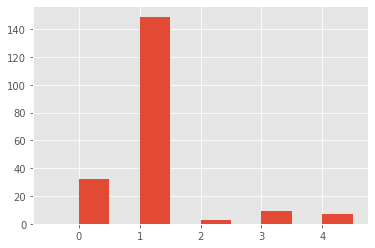

In [ ]:
plt.style.use('ggplot')
plt.hist(Experiment[0], range=[-0.5,4.5])
plt.show()

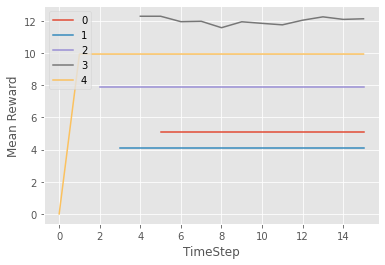

In [ ]:
plt.plot(Experiment[1][:,0])
plt.plot(Experiment[1][:,1])
plt.plot(Experiment[1][:,2])
plt.plot(Experiment[1][:,3])
plt.plot(Experiment[1][:,4])
plt.xlabel('TimeStep')
plt.ylabel('Mean Reward')
plt.legend([0,1,2,3,4])
plt.show()

In [ ]:
from collections import Counter
Mean_Total_Reward_Diff_Initial = []
Mean_Total_UCB_Diff_Initial = []
Percentage_Selected_Optimal_Ad = []
timestep = 100
repeation = 400
confidence_max = 2.0
i = 0.0
while i <= confidence_max:
  TestRun = UCBTester(ad = UCBAds, confidence_level = i)
  Experiment_Mean_Reward = 0
  Experiment_Mean_UCB = 0
  Experiment_Selected_Optimal_Ad = 0

  for j in range(1, repeation + 1):
    Experiment = TestRun.run(timestep)
    #print(Experiment[3])
    Experiment_Mean_Reward =  (Experiment_Mean_Reward * (j-1) + (Experiment[2]/timestep)) / j
    Experiment_Mean_UCB =  (Experiment_Mean_UCB * (j-1) + (Experiment[4]/timestep)) / j
    Experiment_Selected_Optimal_Ad =  (Experiment_Selected_Optimal_Ad * (j-1) + Counter(Experiment[0])[3]) / j
  Mean_Total_Reward_Diff_Initial.append(Experiment_Mean_Reward)
  Mean_Total_UCB_Diff_Initial.append(Experiment_Mean_UCB)
  Percentage_Selected_Optimal_Ad.append(Experiment_Selected_Optimal_Ad/timestep)
  i += 0.1
#print(Mean_Total_Reward_Diff_Initial)
#print(Percentage_Selected_Optimal_Ad)

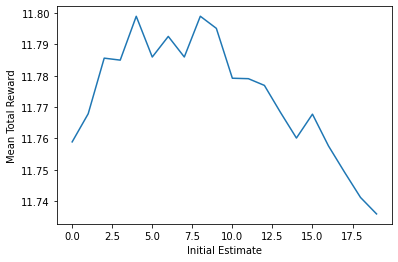

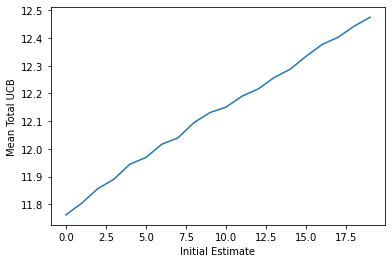

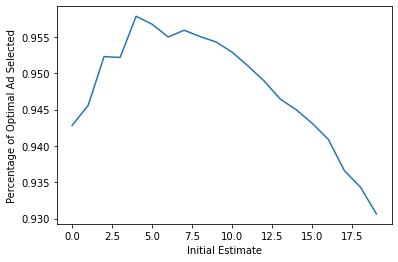

In [ ]:
plt.plot(Mean_Total_Reward_Diff_Initial)
plt.xlabel('Initial Estimate')
plt.ylabel('Mean Total Reward')
plt.show()

plt.plot(Mean_Total_UCB_Diff_Initial)
plt.xlabel('Initial Estimate')
plt.ylabel('Mean Total UCB')
plt.show()

plt.plot(Percentage_Selected_Optimal_Ad)
plt.xlabel('Initial Estimate')
plt.ylabel('Percentage of Optimal Ad Selected')
plt.show()

## **Thompson Sampling Algorithm**

### Bernoulli Thompson Sampling

In [ ]:
Ads_order = [0.4, 0.5, 0.6]

In [ ]:
# Create subclass of base ads which changes normal distribution to binomial distribution
class Bernoulli_Thompson_Ads(BaseAds):
  def __init__(self, q):

    self.alpha = 1 # no. of success - clicked
    self.beta = 1 # no. of failure - no click

    # pass true value to base Ads
    super().__init__(q)

  def charge(self):

    # return 1 / True if random number < probability of success q, i.e. Bernoulli Distribution
    return np.random.random() < self.q

  def update(self, R):

    self.n += 1
    self.alpha += R
    self.beta += (1-R)

  def sample(self, t):

    # return a value sampled from beta distribution, i.e. posterior probability distribution
    # of the true mean value q

    return np.random.beta(self.alpha, self.beta)

In [ ]:
class Bernoulli_Thompson_AdsTester(AdsTester):

  # Create and test a set of ads over a single test run

  def __init__(self, ad = Bernoulli_Thompson_Ads, Ads_order = Ads_order, **kwargs):
    # Create supplied ads type with mean/success value defined by ads order


    self.ads = [ad( q, **kwargs) for q in Ads_order]
    self.InitialReward = self.ads[0].Q
    self.number_of_ads = len(Ads_order)
    self.Cumulative_Reward = 0
    self.UCB = 0

[0.344, 0.6380000000000001, 0.6590909090909092, 0.058625000000000003, 0.6041904761904762, 0.6796153846153846, 0.6092903225806452, 0.6524444444444444, 0.4564878048780488, 0.8829565217391305, 0.7616078431372549, 0.9282857142857147, 0.760655737704918, 0.7228787878787879, 0.8109014084507049, 0.7750000000000001, 0.9630123456790123, 0.6548604651162792, 0.9343516483516483, 0.8115833333333333]


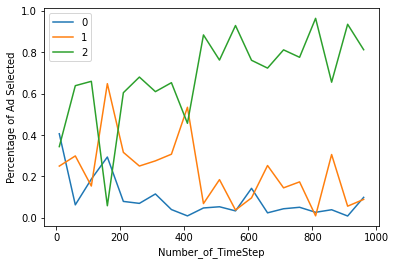

In [ ]:
from collections import Counter
number_of_time_step = 1000
number_of_run = 50
Percentage_Selected_Ad_0 = []
Experiment_Selected_Ad_0 = 0
Percentage_Selected_Ad_1 = []
Experiment_Selected_Ad_1 = 0
Percentage_Selected_Ad_2 = []
Experiment_Selected_Ad_2 = 0

for i in range(10,number_of_time_step+1,50):

  TestRun = Bernoulli_Thompson_AdsTester(ad = Bernoulli_Thompson_Ads)

  for j in range(1, number_of_run + 1):

    Experiment = TestRun.run(i)
    Experiment_Selected_Ad_0 =  (Experiment_Selected_Ad_0 * (j-1) + Counter(Experiment[0])[0]) / j
    Experiment_Selected_Ad_1 =  (Experiment_Selected_Ad_1 * (j-1) + Counter(Experiment[0])[1]) / j
    Experiment_Selected_Ad_2 =  (Experiment_Selected_Ad_2 * (j-1) + Counter(Experiment[0])[2]) / j

  Percentage_Selected_Ad_0.append(Experiment_Selected_Ad_0/i)
  Percentage_Selected_Ad_1.append(Experiment_Selected_Ad_1/i)
  Percentage_Selected_Ad_2.append(Experiment_Selected_Ad_2/i)

print(Percentage_Selected_Ad_2)
plt.plot(range(10,number_of_time_step+1,50),Percentage_Selected_Ad_0)
plt.plot(range(10,number_of_time_step+1,50),Percentage_Selected_Ad_1)
plt.plot(range(10,number_of_time_step+1,50),Percentage_Selected_Ad_2)
plt.xlabel('Number_of_TimeStep')
plt.ylabel('Percentage of Ad Selected')
plt.legend([0,1,2])
plt.show()

[0.5072, 0.204, 0.5957333333333333, 0.3447, 0.39152, 0.5130666666666668, 0.5138285714285714, 0.63325, 0.5144888888888889, 0.51632]


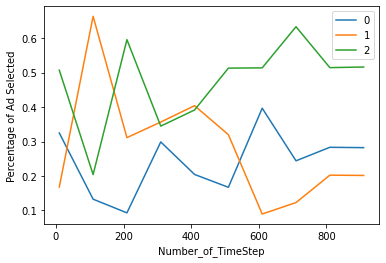

In [ ]:
# Testing for Bayesian UCB (Need 30 min)
from collections import Counter

number_of_time_step = 1000
number_of_run = 25
step_grid = 100
Percentage_Selected_Ad_0 = []
Experiment_Selected_Ad_0 = 0
Percentage_Selected_Ad_1 = []
Experiment_Selected_Ad_1 = 0
Percentage_Selected_Ad_2 = []
Experiment_Selected_Ad_2 = 0

for i in range(100,number_of_time_step+1,step_grid):

  TestRun = Bernoulli_Thompson_AdsTester(ad = BayesianUCBAds, confidence_level =1.96)

  for j in range(1, number_of_run + 1):

    Experiment = TestRun.run(i)
    Experiment_Selected_Ad_0 =  (Experiment_Selected_Ad_0 * (j-1) + Counter(Experiment[0])[0]) / j
    Experiment_Selected_Ad_1 =  (Experiment_Selected_Ad_1 * (j-1) + Counter(Experiment[0])[1]) / j
    Experiment_Selected_Ad_2 =  (Experiment_Selected_Ad_2 * (j-1) + Counter(Experiment[0])[2]) / j

  Percentage_Selected_Ad_0.append(Experiment_Selected_Ad_0/i)
  Percentage_Selected_Ad_1.append(Experiment_Selected_Ad_1/i)
  Percentage_Selected_Ad_2.append(Experiment_Selected_Ad_2/i)

print(Percentage_Selected_Ad_2)
plt.plot(range(10,number_of_time_step+1,step_grid),Percentage_Selected_Ad_0)
plt.plot(range(10,number_of_time_step+1,step_grid),Percentage_Selected_Ad_1)
plt.plot(range(10,number_of_time_step+1,step_grid),Percentage_Selected_Ad_2)

plt.xlabel('Number_of_TimeStep')
plt.ylabel('Percentage of Ad Selected')
plt.legend([0,1,2])
plt.show()

### Gaussian Thompson Sampling

In [ ]:
#tau = posterior precision = 1/variance, miu = posterior mean
class GaussianThompsonAds(BaseAds):
  def __init__(self, q):

    self.tau = 0.0001
    self.miu = 1

    super().__init__(q)

  def sample(self, t):
    return np.random.randn()/np.sqrt(self.tau) + self.miu

  def update(self, R):

    #Call update function from parent class to update estimated mean
    super().update(R)

    #update the mean and precision of posterior
    self.miu = (self.tau * self.miu + self.n * self.Q)/(self.tau + self.n)
    self.tau += 1

In [ ]:
TestRun = AdsTester(GaussianThompsonAds)

Experiment = TestRun.run(10)
print(Experiment)

([3, 0, 2, 4, 1, 1, 2, 4, 4, 4], array([[   0.        ,    0.        ,    0.        ,    0.        ,
           0.        ],
       [   5.66035351,   57.89623785, -103.39530378,   18.0688052 ,
         181.87353159],
       [  20.89879546, -152.1547401 ,  101.93177632,   20.60477131,
         -27.37875174],
       [  21.80136671, -104.74499907,   23.37194766,   19.14396157,
         -56.20300127],
       [  18.89779257,   11.9784995 ,   22.29025952,   19.5181051 ,
          20.18032629],
       [  19.75320462,   21.18949569,   21.89383798,   20.96017612,
          21.56973923],
       [  20.95095389,   22.95865024,   22.4781541 ,   20.00509406,
          21.57159742],
       [  19.96740304,   22.96667597,   21.19073419,   21.36887819,
          19.61870907],
       [  20.79540981,   21.25106066,   21.78893021,   19.05437186,
          22.29406495],
       [  20.46876047,   21.826679  ,   22.13166066,   20.03240712,
          21.97233317],
       [  21.5530116 ,   20.45506855,   22.1075

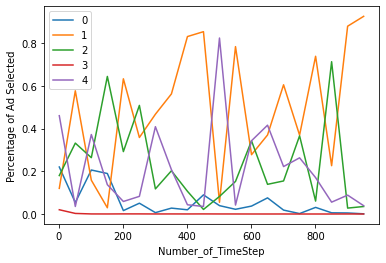

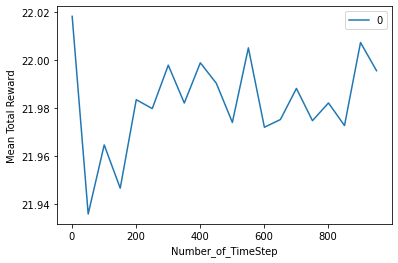

In [ ]:
from collections import Counter
number_of_time_step = 1000
number_of_run = 50
grid = 50
Percentage_Selected_Ad_0 = []
Experiment_Selected_Ad_0 = 0
Percentage_Selected_Ad_1 = []
Experiment_Selected_Ad_1 = 0
Percentage_Selected_Ad_2 = []
Experiment_Selected_Ad_2 = 0
Percentage_Selected_Ad_3 = []
Experiment_Selected_Ad_3 = 0
Percentage_Selected_Ad_4 = []
Experiment_Selected_Ad_4 = 0
Mean_Total_Reward = []
Experiment_Mean_Reward = 0

for i in range(1,number_of_time_step+1,grid):

  TestRun = AdsTester(ad = GaussianThompsonAds)

  for j in range(1, number_of_run + 1):

    Experiment = TestRun.run(i)
    Experiment_Selected_Ad_0 =  (Experiment_Selected_Ad_0 * (j-1) + Counter(Experiment[0])[0]) / j
    Experiment_Selected_Ad_1 =  (Experiment_Selected_Ad_1 * (j-1) + Counter(Experiment[0])[1]) / j
    Experiment_Selected_Ad_2 =  (Experiment_Selected_Ad_2 * (j-1) + Counter(Experiment[0])[2]) / j
    Experiment_Selected_Ad_3 =  (Experiment_Selected_Ad_3 * (j-1) + Counter(Experiment[0])[3]) / j
    Experiment_Selected_Ad_4 =  (Experiment_Selected_Ad_4 * (j-1) + Counter(Experiment[0])[4]) / j
    Experiment_Mean_Reward =  (Experiment_Mean_Reward * (j-1) + (Experiment[2]/i)) / j

  Percentage_Selected_Ad_0.append(Experiment_Selected_Ad_0/i)
  Percentage_Selected_Ad_1.append(Experiment_Selected_Ad_1/i)
  Percentage_Selected_Ad_2.append(Experiment_Selected_Ad_2/i)
  Percentage_Selected_Ad_3.append(Experiment_Selected_Ad_3/i)
  Percentage_Selected_Ad_4.append(Experiment_Selected_Ad_4/i)
  Mean_Total_Reward.append(Experiment_Mean_Reward)

plt.plot(range(1,number_of_time_step+1,grid),Percentage_Selected_Ad_0)
plt.plot(range(1,number_of_time_step+1,grid),Percentage_Selected_Ad_1)
plt.plot(range(1,number_of_time_step+1,grid),Percentage_Selected_Ad_2)
plt.plot(range(1,number_of_time_step+1,grid),Percentage_Selected_Ad_3)
plt.plot(range(1,number_of_time_step+1,grid),Percentage_Selected_Ad_4)
plt.xlabel('Number_of_TimeStep')
plt.ylabel('Percentage of Ad Selected')
plt.legend([0,1,2,3,4])
plt.show()

plt.plot(range(1,number_of_time_step+1,grid),Mean_Total_Reward)
plt.xlabel('Number_of_TimeStep')
plt.ylabel('Mean Total Reward')
plt.legend([0,1,2,3,4])
plt.show()